In [14]:
#Let's import the necessary packages:
import json
import re
import pandas as pd
from textblob import TextBlob
import spacy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
tqdm.pandas() 
import random
from transformers import GPT2Tokenizer
from transformers import AdamW, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, TrainingArguments, Trainer, AdamW
from peft import get_peft_model, LoraConfig, TaskType
import peft
from sklearn.model_selection import train_test_split
import wandb
from rouge_score import rouge_scorer
import evaluate

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000) # 100 means 100 characters in the col

In [2]:
df = pd.read_csv("sampled_conversational_data.csv")

In [3]:
df.head()

,Conversation ID,Turn ID,Text,cleaned_text
0,169,1,My insurance does not cover PMS,my insurance does not cover PMS
1,169,2,Then tell them I had a seizure.,then tell them i had a seizure
2,169,3,Is this about Sarah Lawrence? You punishing me?,is this about Sarah Lawrence you punishing me
3,169,4,I thought you were punishing me.,i thought you were punishing me
4,169,5,Why can't we agree on this?,why can not we agree on this


In [4]:
df.shape

(7126, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7126 entries, 0 to 7125
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Conversation ID  7126 non-null   int64 
 1   Turn ID          7126 non-null   int64 
 2   Text             7126 non-null   object
 3   cleaned_text     7126 non-null   object
dtypes: int64(2), object(2)
memory usage: 222.8+ KB


In [6]:
# Show the unique count of 'Conversation ID':
df['Conversation ID'].nunique()




714

C:\Users\aktha\anaconda3\envs\tf_env\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Token Length Statistics:
count    714.000000
mean     118.418768
std       49.130872
min       11.000000
25%       83.250000
50%      110.000000
75%      147.750000
max      341.000000
Name: token_length, dtype: float64


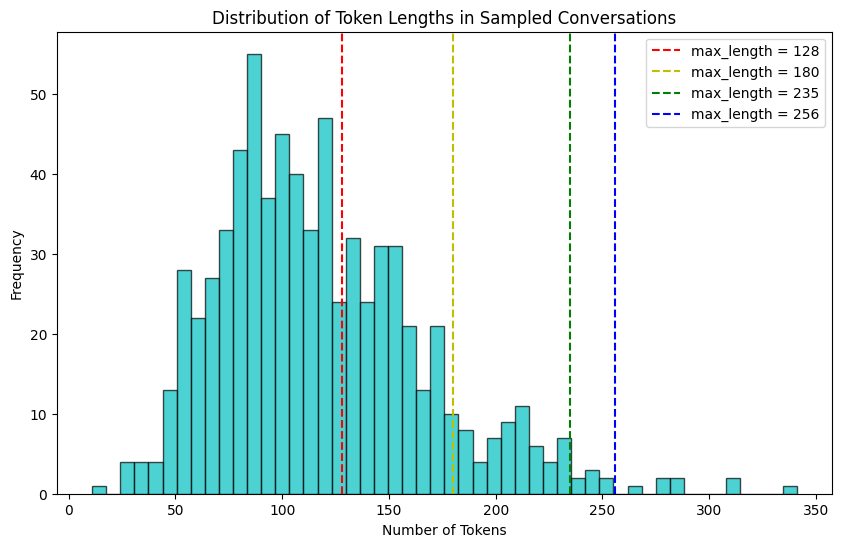

Token Length Percentiles:
0.50    110.00
0.75    147.75
0.90    182.00
0.95    213.35
Name: token_length, dtype: float64


In [7]:

# Load the GPT-2 tokenizer:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Concatenate all conversation turns into a single string per conversation for token length analysis:
all_conversations_text = df.groupby('Conversation ID')['cleaned_text'].apply(lambda x: " ".join(x)).tolist()

# Calculate the number of tokens for each conversation:
conversation_token_lengths = [len(tokenizer.tokenize(convo)) for convo in all_conversations_text]

# Create a DataFrame for analysis:
df_lengths = pd.DataFrame({'conversation': all_conversations_text, 'token_length': conversation_token_lengths})

# Display basic statistics about token lengths:
print("Token Length Statistics:")
print(df_lengths['token_length'].describe())

# Plot the distribution of token lengths:
plt.figure(figsize=(10, 6))
plt.hist(df_lengths['token_length'], bins=50, color='c', edgecolor='k', alpha=0.7)
plt.title('Distribution of Token Lengths in Sampled Conversations')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(x=128, color='r', linestyle='--', label='max_length = 128')
plt.axvline(x=180, color='y', linestyle='--', label='max_length = 180')
plt.axvline(x=235, color='g', linestyle='--', label='max_length = 235')
plt.axvline(x=256, color='b', linestyle='--', label='max_length = 256')
plt.legend()
plt.show()

# Calculate percentiles to understand token coverage:
percentiles = df_lengths['token_length'].quantile([0.5, 0.75, 0.9, 0.95])
print("Token Length Percentiles:")
print(percentiles)


**Summary Highlights:**
* **Median Token Length (50th Percentile):** `110 tokens` This means that half of the conversations have fewer than `110` tokens.
* **75th Percentile Token Length:** `147.75 tokens` `75%` of the conversations have fewer than `148` tokens.
* **90th Percentile Token Length:** `182 tokens` `90%` of the conversations have fewer than `182` tokens, which suggests that a max length of around `180` would cover most of the data.
* **95th Percentile Token Length:** `213.35 tokens` `95%` of conversations have fewer than `214` tokens, indicating that only a small portion of conversations would exceed this length.

**Visual Insight:**

* **Max Length of 128 Tokens:** This length covers a bit more than `50%` of the conversations.
* **Max Length of 180 Tokens:** This covers approximately `90%` of the conversations, making it a strong candidate for efficient training.
* **Max Length of 235 Tokens:** Covers almost all conversations but might result in higher memory usage.

**Recommendation:**
Based on the analysis, a max token length of `180` strikes a good balance between covering a majority of the conversations `(90%)` and keeping the input manageable for GPT-2 fine-tuning, making it a practical choice for training on limited resources.

In [8]:
# Load the GPT-2 tokenizer:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# GPT-2 doesn't have a pad token, so we'll set the end of sequence (EOS) token as the padding token:
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the `cleaned_text` column:
df['input_ids'] = df['cleaned_text'].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=180, padding='max_length')
)

# Inspect the first few rows after tokenization:
df[['cleaned_text', 'input_ids']].head()


C:\Users\aktha\anaconda3\envs\tf_env\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,cleaned_text,input_ids
0,my insurance does not cover PMS,"[1820, 5096, 857, 407, 3002, 3122, 50, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"
1,then tell them i had a seizure,"[8524, 1560, 606, 1312, 550, 257, 22338, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"
2,is this about Sarah Lawrence you punishing me,"[271, 428, 546, 10490, 13914, 345, 28641, 502, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"
3,i thought you were punishing me,"[72, 1807, 345, 547, 28641, 502, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"
4,why can not we agree on this,"[22850, 460, 407, 356, 4236, 319, 428, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, ...]"


In [9]:
# Split the data into train (80%), validation (10%), and test (10%):
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Check the sizes of the splits:
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 5700
Validation set size: 713
Test set size: 713


In [10]:
# Create input-output pairs based on conversation turns:
def create_input_output_pairs(df):
    conversation_pairs = []
    grouped_conversations = df.groupby('Conversation ID')
    
    for _, group in grouped_conversations:
        group = group.sort_values(by='Turn ID')
        for i in range(len(group) - 1):
            input_text = group.iloc[i]['input_ids']
            response_text = group.iloc[i + 1]['input_ids']
            conversation_pairs.append((input_text, response_text))
    
    return conversation_pairs

# Generate input-output pairs for train, validation, and test datasets:
train_pairs = create_input_output_pairs(train_df)
val_pairs = create_input_output_pairs(val_df)
test_pairs = create_input_output_pairs(test_df)

# Check the number of pairs generated:
print(f"Total train pairs: {len(train_pairs)}")
print(f"Total validation pairs: {len(val_pairs)}")
print(f"Total test pairs: {len(test_pairs)}")


Total train pairs: 4986
Total validation pairs: 267
Total test pairs: 254


In [11]:
import torch
from torch.utils.data import Dataset

class ConversationDataset(Dataset):
    def __init__(self, tokenized_pairs):
        self.data = tokenized_pairs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, response_ids = self.data[idx]  # Each entry in data is (input_ids, response_ids)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(response_ids, dtype=torch.long)
        }


In [12]:
# Instantiate datasets:
train_dataset = ConversationDataset(train_pairs)
val_dataset = ConversationDataset(val_pairs)

# Create DataLoaders:
batch_size = 16  # Adjust based on your GPU memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(f"Total train batches: {len(train_dataloader)}")
print(f"Total validation batches: {len(val_dataloader)}")


Total train batches: 312
Total validation batches: 17


In [15]:
# Load the GPT-2 model:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Apply LoRA:
peft_model = peft.get_peft_model(model, peft.LoraConfig(r=8, lora_alpha=16, lora_dropout=0.1))

# Initialize the optimizer (AdamW):
from torch.optim import AdamW
optimizer = AdamW(peft_model.parameters(), lr=5e-5)


C:\Users\aktha\anaconda3\envs\tf_env\lib\site-packages\peft\tuners\lora\layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [16]:
# Initialize WandB:
wandb.init(project="gpt2-lora-chatbot", name="lora-finetuning")

# Watch the model to log gradients and weights:
wandb.watch(peft_model)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aktham-momani81 (aktham-momani81-university-of-san-diego). Use `wandb login --relogin` to force relogin


[]

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [21]:
training_args = TrainingArguments(
    output_dir="./results",
    run_name="gpt2-lora-chatbot",  # Unique run name for WandB
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=34, #16
    per_device_eval_batch_size=32, #16
    num_train_epochs=3,
    report_to="wandb",  # Reports metrics to WandB
    save_steps=1000,
    save_total_limit=3
)


In [22]:
# Create the Trainer instance
trainer = Trainer(
    model=peft_model,  # The LoRA fine-tuned model
    args=training_args,
    train_dataset=train_dataset,  # Train dataset
    eval_dataset=val_dataset,  # Validation dataset
    optimizers=(optimizer, None)  # Custom optimizer (AdamW)
)

# Start training
trainer.train()


Step,Training Loss,Validation Loss


TrainOutput(global_step=441, training_loss=1.3244601288079674, metrics={'train_runtime': 21736.0668, 'train_samples_per_second': 0.688, 'train_steps_per_second': 0.02, 'total_flos': 1378813257031680.0, 'train_loss': 1.3244601288079674, 'epoch': 3.0})

In [23]:
# Save the model and tokenizer:
output_dir = './gpt2_chatbot_model'

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to ./gpt2_chatbot_model


In [25]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the model and tokenizer from the saved directory:
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model = GPT2LMHeadModel.from_pretrained(output_dir)

# Ensure that the tokenizer uses EOS token for padding:
tokenizer.pad_token = tokenizer.eos_token

def generate_response(input_text, model, tokenizer, max_length=50, num_beams=5, top_p=0.9, top_k=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    generated_ids = model.generate(
        input_ids,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=num_beams,  # Beam search for better quality output
        top_p=top_p,          # Nucleus sampling to add randomness
        top_k=top_k,          # Limit to top-k tokens
        do_sample=True        # Enable sampling
    )
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Test the loaded model with an input:
input_text = "Hello! How are you?"
generated_response = generate_response(input_text, model, tokenizer)
print("Generated Response:", generated_response)


# Test the loaded model with an input:
input_text = "Hello! How are you?"
generated_response = generate_response(input_text, model, tokenizer)
print("Generated Response:", generated_response)


Some weights of the model checkpoint at ./gpt2_chatbot_model were not used when initializing GPT2LMHeadModel: ['transformer.h.0.attn.c_attn.base_layer.bias', 'transformer.h.0.attn.c_attn.base_layer.weight', 'transformer.h.0.attn.c_attn.lora_A.default.weight', 'transformer.h.0.attn.c_attn.lora_B.default.weight', 'transformer.h.1.attn.c_attn.base_layer.bias', 'transformer.h.1.attn.c_attn.base_layer.weight', 'transformer.h.1.attn.c_attn.lora_A.default.weight', 'transformer.h.1.attn.c_attn.lora_B.default.weight', 'transformer.h.10.attn.c_attn.base_layer.bias', 'transformer.h.10.attn.c_attn.base_layer.weight', 'transformer.h.10.attn.c_attn.lora_A.default.weight', 'transformer.h.10.attn.c_attn.lora_B.default.weight', 'transformer.h.11.attn.c_attn.base_layer.bias', 'transformer.h.11.attn.c_attn.base_layer.weight', 'transformer.h.11.attn.c_attn.lora_A.default.weight', 'transformer.h.11.attn.c_attn.lora_B.default.weight', 'transformer.h.2.attn.c_attn.base_layer.bias', 'transformer.h.2.attn.c_at

Generated Response: Hello! How are you?
In the one of the people who is not only that the people who is not only one of the world history of the way back to which is the same as it is a single-Outs]
(s
Generated Response: Hello! How are you?


In the people with the way back to all this, in the way too much of the same as the same as a personas of the way back to which are in which is not only the city by the
